In [1]:
import torch
import torch.optim as optim
import torchvision.utils as utils
import torch.nn as nn
import torch.distributions as distributions
import numpy as np
import matplotlib.pyplot as plt
import h5py
import time
import os

from scipy.linalg import orth
from torch.utils.data import TensorDataset
from torch.optim import lr_scheduler
from tqdm import trange
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve

torch.manual_seed(2022)
torch.set_default_dtype(torch.float64)

class Hyperparameters():
    def __init__(self, base_dim, weight_norm, coupling_bn):
        self.base_dim = base_dim
        self.weight_norm = weight_norm
        self.coupling_bn = coupling_bn
        
class fully_connected(nn.Module):
    
    def __init__(self, units, layers, in_dim, out_dim, activation='ReLU'):
        super(fully_connected, self).__init__()
        
        self.activation = {'ReLU': nn.ReLU(), 'Sigmoid': nn.Sigmoid(), 'Tanh': nn.Tanh()}[activation]
        self.in_layer = [nn.Linear(in_dim, units), self.activation]
        self.hidden_layer_lst = [nn.Linear(units, units), self.activation] * (layers - 2)
        self.feature_layer = [nn.Linear(units, out_dim)]
        self.fcn = nn.ModuleList(self.in_layer + self.hidden_layer_lst + self.feature_layer)
        
    def forward(self, x):
        for h in self.fcn:
            x = h(x)
        return x
    
class WeightNormFC(nn.Module):
    def __init__(self, in_dim, out_dim, weight_norm=True, scale=False):
        super(WeightNormFC, self).__init__()
        if weight_norm:
            self.dense = nn.utils.weight_norm(nn.Linear(in_dim, out_dim))
            
            if not scale:
                self.dense.weight_g.data = torch.ones_like(self.dense.weight_g.data)
                self.dense.weight_g.requires_grad = False    # freeze scaling
        else:
            self.dense = nn.Linear(in_dim, out_dim)

    def forward(self, x):
        return self.dense(x)
    
    
class DenseModule(nn.Module):
    def __init__(self, in_dim, dim, out_dim, weight_norm):
        super(DenseModule, self).__init__()
        self.block = nn.Sequential(WeightNormFC(in_dim, dim, weight_norm),
                                   nn.ReLU(),
                                   WeightNormFC(dim, dim, weight_norm),
                                   nn.ReLU(),
                                   WeightNormFC(dim, out_dim, weight_norm))

    def forward(self, x):
        return self.block(x)

    
class AbstractCoupling(nn.Module):
    def __init__(self, mask_config, hps):
        super(AbstractCoupling, self).__init__()
      
        self.weight_norm = hps.weight_norm
        self.coupling_bn = hps.coupling_bn
        self.mask_config = mask_config

    def batch_stat(self, x):
        mean = torch.mean(x, dim=0, keepdim=True)
        var = torch.mean((x - mean)**2, dim=0, keepdim=True)
        return mean, var

    
class ChannelwiseAffineCoupling(AbstractCoupling):
    def __init__(self, in_out_dim, mid_dim, mask_config, hps):
        super(ChannelwiseAffineCoupling, self).__init__(mask_config, hps)
        self.s_net = DenseModule(in_out_dim//2, mid_dim, in_out_dim//2, self.weight_norm)
        self.t_net = DenseModule(in_out_dim//2, mid_dim, in_out_dim//2, self.weight_norm)
        
    def forward(self, x, reverse=False):
        [_, D] = list(x.size())
        
        if self.mask_config:
            (on, off) = x.split(D//2, dim=1)
        else:
            (off, on) = x.split(D//2, dim=1)
                
        if reverse == False:
            # Forward
            self.scale = self.s_net(off)
            self.trans = self.t_net(off)
            
            on = (torch.exp(torch.atan(self.scale))) * on + self.trans
            log_det_J = torch.sum(torch.atan(self.scale), dim=1)
            
            if self.coupling_bn:
                mean, var = self.batch_stat(on)
                on = self.out_bn(on)
                on = (on - mean) / torch.sqrt(var + 1e-5)
                log_det_J = log_det_J - 0.5 * torch.sum(torch.log(var + 1e-5), dim=1)

        else:
            # Reverse
            self.scale = self.s_net(off)
            self.trans = self.t_net(off)
            log_det_J = torch.zeros(off.shape[0]).to(x.device)
            
            if self.coupling_bn:
                mean, var = self.batch_stat(on)
                on = on * torch.exp(0.5 * torch.log(var + 1e-5)) + mean
                log_det_J = 0.5 * torch.sum(torch.log(var + 1e-5), dim=1)
            
            on = (on - self.trans) / (torch.exp(torch.atan(self.scale)))
            log_det_J = log_det_J - torch.sum(torch.atan(self.scale), dim=1)
        
        if self.mask_config:
            x = torch.cat((on, off), 1)
        else:
            x = torch.cat((off, on), 1)
        
        return x, log_det_J
    
    
class ChannelwiseCoupling(nn.Module):
    def __init__(self, in_out_dim, mid_dim, mask_config, hps):
        super(ChannelwiseCoupling, self).__init__()
        self.coupling = ChannelwiseAffineCoupling(in_out_dim, mid_dim, mask_config, hps)


    def forward(self, x, reverse=False):
        return self.coupling(x, reverse)
        
        
class RealNVP(nn.Module):
    def __init__(self, in_out_dim, prior, hps):
        super(RealNVP, self).__init__()
        self.prior = prior
        self.hps = hps
        mid_dim = hps.base_dim
        self.in_out_dim = in_out_dim
        self.s1_chan = self.channelwise_combo(in_out_dim, mid_dim, hps)
        
    def channelwise_combo(self, in_out_dim, mid_dim, hps):
        return nn.ModuleList([
                ChannelwiseCoupling(in_out_dim, mid_dim, 0., hps),
                ChannelwiseCoupling(in_out_dim, mid_dim, 1., hps),
                ChannelwiseCoupling(in_out_dim, mid_dim, 0., hps),
                ChannelwiseCoupling(in_out_dim, mid_dim, 1., hps),
                ChannelwiseCoupling(in_out_dim, mid_dim, 0., hps),
                ChannelwiseCoupling(in_out_dim, mid_dim, 1., hps),
                ChannelwiseCoupling(in_out_dim, mid_dim, 0., hps),
                ChannelwiseCoupling(in_out_dim, mid_dim, 1., hps),
                ChannelwiseCoupling(in_out_dim, mid_dim, 0., hps),
                ChannelwiseCoupling(in_out_dim, mid_dim, 1., hps)])

    def forward(self, x, reverse=False):
        log_det_J = torch.zeros(x.size()[0]).to(x.device)

        if reverse == False:
            for i in range(len(self.s1_chan)):
                x, inc = self.s1_chan[i](x)
                log_det_J = log_det_J + inc
        else:            
            for i in reversed(range(len(self.s1_chan))):
                x, inc = self.s1_chan[i](x, reverse=True)
                log_det_J = log_det_J + inc
                
        return x, log_det_J
        
    def weight_reg(self, x):
        weight_scale = None
        for name, param in self.named_parameters():
            param_name = name.split('.')[-1]
            if param_name in ['weight_g', 'scale'] and param.requires_grad:
                if weight_scale is None:
                    weight_scale = torch.pow(param, 2).sum()
                else:
                    weight_scale = weight_scale + torch.pow(param, 2).sum()
        return weight_scale

In [2]:
device = torch.device("cuda:0")
model_name = 'Diffusion'

# model hyperparameters
batch_size = 64
hps = Hyperparameters(
    base_dim=100, 
    weight_norm=False, 
    coupling_bn=False)

hdf5_file = './Data/Stochastic_Diffusion_Dataset.hdf5'
with h5py.File(hdf5_file, 'r') as f:
    D_data = f['Diffusion'][()]
    f_data = f['Source'][()]
    D_params_data = f['Diffusion_Params'][()]
    f_params_data = f['Source_Params'][()]
    u_data = f['Concentration'][()]
    
lambda_data = np.concatenate([D_params_data, f_params_data], axis=1)

Stochastic_Data = np.load('./Data/Stochastic_Diffusion_Mode_Data.npz')
D_weights = torch.from_numpy(Stochastic_Data['D_kl_weights']).to(device)
D_modes = torch.from_numpy(Stochastic_Data['D_kl_modes']).to(device)
D_mean = torch.from_numpy(Stochastic_Data['D_mean']).view(1, -1).to(device)
f_mean = torch.from_numpy(Stochastic_Data['f_mean']).to(device)
f_std = torch.from_numpy(Stochastic_Data['f_std']).to(device)

def Diffusion_field(D_params):
    return torch.exp(D_mean + (D_params * D_weights) @ D_modes.T)

def Source_term(f_params):
    return f_mean + f_std * f_params

# dimension setting
"""
In practice, we find it advantageous to add zero padding in the input layers to improve the expressive 
power of INN. For further details, one can refer to the paper "Analyzing Inverse Problems with Invertible 
Neural Networks" and its source code.
"""
ndim_D_params = D_params_data.shape[1]
ndim_f_params = f_params_data.shape[1]
ndim_z = 6
ndim_c_u = 6
ndim_lambda = ndim_D_params + ndim_f_params
ndim_padding = ndim_c_u + ndim_z - ndim_lambda

N_train = 4000
N_test = 1000
lambda_train = torch.from_numpy(lambda_data[0:N_train])
u_train = torch.from_numpy(u_data[0:N_train])
D_train = torch.from_numpy(D_data[0:N_train])
f_train = torch.from_numpy(f_data[0:N_train])

lambda_test = torch.from_numpy(lambda_data[N_train:(N_train+N_test)])
u_test = torch.from_numpy(u_data[N_train:(N_train+N_test)])
D_test = torch.from_numpy(D_data[N_train:(N_train+N_test)])
f_test = torch.from_numpy(f_data[N_train:(N_train+N_test)])

# data loader
train_loader = torch.utils.data.DataLoader(TensorDataset(lambda_train, u_train), batch_size=batch_size, 
                                           shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(TensorDataset(lambda_test, u_test), batch_size=batch_size,
                                           shuffle=True, drop_last=True)

# latent variable definition
latent = distributions.Normal(
    torch.tensor(0.).to(device), torch.tensor(1.).to(device))
prior = distributions.Normal(
    torch.tensor(0.).to(device), torch.tensor(1.).to(device))
padding = distributions.Normal(
    torch.tensor(0.).to(device), torch.tensor(0.01).to(device))

In [3]:
# INN 
in_out_dim = ndim_lambda + ndim_padding
INN = RealNVP(in_out_dim, prior=prior, hps=hps).to(device)
# NB_Net
TkNet = fully_connected(units=64, layers=8, in_dim=1, out_dim=ndim_c_u, activation='Tanh').to(device)

params_INN = [p for p in INN.parameters() if p.requires_grad]
params_TkNet = [p for p in TkNet.parameters() if p.requires_grad]
combined_params = params_INN + params_TkNet
        
# optimizer
lr = 1e-3
momentum = 0.9
decay = 0.99
optimizer = optim.Adam(combined_params, lr=lr, betas=(momentum, decay), eps=1e-7)

# learning rate decay
scheduler = lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.8, verbose=False)

In [3]:
def equation_loss(D, u, f):
    D_lb = D[:, 0:-1]
    D_ub = D[:, 1:]
    u_x = torch.matmul(u, difference_matrix)
    ux_lb = u_x[:, 0:-1]
    ux_ub = u_x[:, 1:]
    quad_Lu = (D_lb * ux_lb - D_ub * ux_ub) / h
    quad_f = h * torch.ones_like(quad_Lu) * f.view(-1, 1) / h
    res = quad_Lu - quad_f
    return torch.mean(res ** 2)

def Distance_func(x):
    return x * (1 - x)

def Dirichlet_BC_func(x):
    return x

def log_q_uz(out_lambda_padding, log_det_J):
    """
    log P(u, z)
    """
    out_lambda = out_lambda_padding[:, 0:ndim_lambda]
    out_padding = out_lambda_padding[:, -ndim_padding:]
    log_p_lambda = torch.sum(prior.log_prob(out_lambda), dim=1)
    log_p_padding = torch.sum(padding.log_prob(out_padding), dim=1)
    return log_p_lambda + log_p_padding + log_det_J

# independence loss
def independence_loss(out_lambda_padding, log_det_J, out_lambda_padding_star, log_det_J_star, normal_dist):
    return torch.mean(torch.square(log_q_uz(out_lambda_padding, log_det_J) - log_q_uz(out_lambda_padding_star, log_det_J_star) - normal_dist))

# forward fitting
def forward_fitting(u, out_u):
    l2_fit_err = torch.norm(u - out_u, dim=1) / torch.norm(u, dim=1)
    return l2_fit_err.mean()

# spatial difference matrix
Nx_dim = D_data.shape[1]
difference_matrix = torch.diag(-torch.ones(Nx_dim-1), -1) + torch.diag(torch.ones(Nx_dim-1), 1)
difference_matrix[0, [0, 1]] = torch.Tensor([-2, 2])
difference_matrix[-1, [-2, -1]] = torch.Tensor([-2, 2])
difference_matrix = (Nx_dim-1) * 0.5 * difference_matrix.T.to(device)

# collocation points
x = torch.linspace(0, 1, Nx_dim).view(1, -1)
h = 1 / Nx_dim
x_f = x.view(-1, 1).to(device)
Distance_value = Distance_func(x_f).reshape(1, -1).to(device)
BC_value = Dirichlet_BC_func(x_f).reshape(1, -1).to(device)

In [4]:
def train():
    running_loss = 0.
    running_equ = 0.
    running_fit = 0.
    running_ind = 0.
    INN.train()
    TkNet.train()

    for batch_idx, (_lambda, u) in enumerate(train_loader):
        batch_idx += 1
        optimizer.zero_grad()
        _lambda = _lambda.to(device)
        D_params, f_params = _lambda[:, 0:ndim_D_params], _lambda[:, -ndim_f_params:]
        paddings = padding.rsample([batch_size, ndim_padding])
        lambda_paddings = torch.cat([_lambda, paddings], dim=1)
        z_star = torch.randn(batch_size, ndim_z).to(device)
        u = u.to(device)
        
        # reconstruct stochastic field
        Diffusion_value = Diffusion_field(D_params)
        source_value = f_mean + f_std * f_params
        
        # forward mapping
        out_cz = INN(lambda_paddings)[0]
        out_c, out_z = out_cz[:, 0:ndim_c_u], out_cz[:, -ndim_z:]
        
        # calculate Basis function
        Basis_tau_value = TkNet(x_f)
        Basis_tau_orth_value = torch.qr(Basis_tau_value)[0]
        Basis_tau = Basis_tau_orth_value.T.to(device)
        out_tau = out_c @ Basis_tau
        out_u = BC_value + out_tau * Distance_value
        
        # inverse mapping
        cz_star = torch.cat((out_c, z_star), dim=1)
        out_lambda_padding, log_det_J = INN(out_cz, reverse=True)
        out_lambda_padding_star, log_det_J_star = INN(cz_star, reverse=True)
        
        # equation loss
        loss_equ = equation_loss(Diffusion_value, out_u, source_value)
        loss_fit = forward_fitting(u, out_u)
        # independence loss
        normal_dist = torch.sum(latent.log_prob(out_z) - latent.log_prob(z_star), dim=1)
        loss_ind = independence_loss(out_lambda_padding, log_det_J, out_lambda_padding_star, log_det_J_star, normal_dist)
        # total loss
        loss = weight_equ * loss_equ + weight_ind * loss_ind
        
        running_loss += loss.item()
        running_equ += loss_equ.item()
        running_fit += loss_fit.item()
        running_ind += loss_ind.item()

        loss.backward()
        optimizer.step()

    mean_loss = running_loss / batch_idx
    mean_equ = running_equ / batch_idx
    mean_fit = running_fit / batch_idx
    mean_ind = running_ind / batch_idx
    
    total_trn_loss_lst.append(mean_loss)
    equ_trn_loss_lst.append(mean_equ)
    fit_trn_loss_lst.append(mean_fit)
    ind_trn_loss_lst.append(mean_ind)
    return (mean_loss, mean_equ, mean_fit, mean_ind)

def test():
    running_loss = 0.
    running_equ = 0.
    running_fit = 0.
    running_ind = 0.
    INN.eval()
    TkNet.eval()

    for batch_idx, (_lambda, u) in enumerate(test_loader):
        batch_idx += 1
        _lambda = _lambda.to(device)
        D_params, f_params = _lambda[:, 0:ndim_D_params], _lambda[:, -ndim_f_params:]
        paddings = padding.rsample([batch_size, ndim_padding])
        lambda_paddings = torch.cat([_lambda, paddings], dim=1)
        z_star = torch.randn(batch_size, ndim_z).to(device)
        u = u.to(device)
        
        # reconstruct stochastic field
        Diffusion_value = Diffusion_field(D_params)
        source_value = f_mean + f_std * f_params
        
        # forward mapping
        out_cz = INN(lambda_paddings)[0]
        out_c, out_z = out_cz[:, 0:ndim_c_u], out_cz[:, -ndim_z:]
        
        # calculate Basis function
        Basis_tau_value = TkNet(x_f)
        Basis_tau_orth_value = torch.qr(Basis_tau_value)[0]
        Basis_tau = Basis_tau_orth_value.T.to(device)
        out_tau = out_c @ Basis_tau
        # calculte simulated u (with hard BC)
        out_u = BC_value + out_tau * Distance_value
        
        # inverse mapping
        cz_star = torch.cat((out_c, z_star), dim=1)
        out_lambda_padding, log_det_J = INN(out_cz, reverse=True)
        out_lambda_padding_star, log_det_J_star = INN(cz_star, reverse=True)
        
        # equation loss
        loss_equ = equation_loss(Diffusion_value, out_u, source_value)
        loss_fit = forward_fitting(u, out_u)
        # independence loss
        normal_dist = torch.sum(latent.log_prob(out_z) - latent.log_prob(z_star), dim=1)
        loss_ind = independence_loss(out_lambda_padding, log_det_J, out_lambda_padding_star, log_det_J_star, normal_dist)
        # total loss
        loss = weight_equ * loss_equ + weight_ind * loss_ind
        
        running_loss += loss.item()
        running_equ += loss_equ.item()
        running_fit += loss_fit.item()
        running_ind += loss_ind.item()

    mean_loss = running_loss / batch_idx
    mean_equ = running_equ / batch_idx
    mean_fit = running_fit / batch_idx
    mean_ind = running_ind / batch_idx
    
    total_test_loss_lst.append(mean_loss)
    equ_test_loss_lst.append(mean_equ)
    fit_test_loss_lst.append(mean_fit)
    ind_test_loss_lst.append(mean_ind)
    return (mean_loss, mean_equ, mean_fit, mean_ind)

def log_out(epoch, train_metric_series, test_metric_series):
    print('Epoch %d:' % epoch)
    print('===> Average train loss: %.6f,\t equation loss: %.6f,\t fit loss: %.6f,\t ind loss: %.6f' % 
          (train_metric_series[0], train_metric_series[1], train_metric_series[2], train_metric_series[3]))
    print('===> Average test loss: %.6f,\t equation loss: %.6f,\t fit loss: %.6f,\t ind loss: %.6f' % 
          (test_metric_series[0], test_metric_series[1], test_metric_series[2], test_metric_series[3]))

def save_loss_information():
    total_trn_loss = np.array(total_trn_loss_lst).reshape(-1, 1)
    equ_trn_loss = np.array(equ_trn_loss_lst).reshape(-1, 1)
    fit_trn_loss = np.array(fit_trn_loss_lst).reshape(-1, 1)
    ind_trn_loss = np.array(ind_trn_loss_lst).reshape(-1, 1)

    total_test_loss = np.array(total_test_loss_lst).reshape(-1, 1)
    equ_test_loss = np.array(equ_test_loss_lst).reshape(-1, 1)
    fit_test_loss = np.array(fit_test_loss_lst).reshape(-1, 1)
    ind_test_loss = np.array(ind_test_loss_lst).reshape(-1, 1)

    np.save('./Loss_Information/train_losses_PI_INN_' + model_name + '.npy', np.concatenate([total_trn_loss, equ_trn_loss, 
                                                       fit_trn_loss, ind_trn_loss], axis=1))
    np.save('./Loss_Information/test_losses_PI_INN_' + model_name + '.npy', np.concatenate([total_test_loss, equ_test_loss, 
                                                      fit_test_loss, ind_test_loss], axis=1))

In [6]:
max_epoch = 10000
epoch = 0
weight_equ = 5.
weight_ind = 1.
optimal_loss = float('inf')
start_time = time.time()

# monitor loss terms
total_trn_loss_lst, total_test_loss_lst = [], []
equ_trn_loss_lst, equ_test_loss_lst = [], []
fit_trn_loss_lst, fit_test_loss_lst = [], []
ind_trn_loss_lst, ind_test_loss_lst = [], []

INN_model_path = './models/INN_{}.pt'.format(model_name)
TkNet_model_path = './models/TkNet_{}.pt'.format(model_name)
if not os.path.exists(INN_model_path):
    try:
        for epoch in range(max_epoch):
            epoch += 1
            train_metric_series = train()
            test_metric_series = test()
            log_out(epoch, train_metric_series, test_metric_series)

            if test_metric_series[0] < optimal_loss:
                optimal_loss = test_metric_series[0]
                torch.save(INN, './models/INN_' + model_name + '.pt')
                torch.save(TkNet, './models/TkNet_' + model_name + '.pt')

            scheduler.step()
    except KeyboardInterrupt:
        pass
    finally:
        print("Time elapsed for training: %f " % (time.time() - start_time))
else:
    INN = torch.load(INN_model_path)
    TkNet = torch.load(TkNet_model_path)

In [8]:
# forward prediction
padding_test = padding.rsample([N_test, ndim_padding])
lambda_padding_test = torch.cat([lambda_test.to(device), padding_test], dim=1)
cz_pred = INN(lambda_padding_test)[0]
c_pred, z_pred = cz_pred[:, 0:ndim_c_u], cz_pred[:, -ndim_z:]

# calculate Basis function
Basis_tau_value = TkNet(x_f)
Basis_tau_orth_value = torch.qr(Basis_tau_value)[0]
Basis_tau = Basis_tau_orth_value.T.to(device)
tau_pred = c_pred @ Basis_tau
# calculte simulated u (with hard BC)
u_pred = BC_value + tau_pred * Distance_value

# l2 relative error
def l2_relative_error(y, y_pred):
    return torch.norm(y - y_pred, dim=1) / torch.norm(y, dim=1)
l2_err_u = l2_relative_error(u_test, u_pred.cpu())

print("l2 relative error (Mean):", l2_err_u.mean().item())
print("l2 relative error (Standard Deviation):", l2_err_u.std().item())

class Diffusion_Equation_Data:
    def __init__(self):
        pass
    def source(self, x, source_value):
        return np.ones_like(x) * source_value
    def is_dirichlet_boundary(self, x):
        return np.where((x == 0) | (x == 1))[0]
    def dirichlet(self, x):
        return x
    
node = np.linspace(0, 1, Nx_dim).reshape(-1, 1)
elem = np.concatenate([np.arange(1, Nx_dim).reshape(-1, 1), np.arange(2, Nx_dim+1).reshape(-1, 1)], axis=1)

pde = Diffusion_Equation_Data()
pde_dict = {'pde': pde, 'node': node, 'elem': elem}

l2 relative error (Mean): 0.0035095616567714667
l2 relative error (Standard Deviation): 0.003762610429628411


In [10]:
def PI_INN_Bayesian_Sampling(u_obs, N_sample, sensor_index=None):
    """
    u_observation: 1 x N_sensors 
    """
    c_hat = reverse_u(u_obs.to(device), Basis_tau, sensor_index)
    cz_sample = torch.cat([c_hat.repeat(N_sample, 1), latent.rsample([N_sample, ndim_z])], dim=1)
    lambda_sample = INN(cz_sample, reverse=True)[0][:, 0:ndim_lambda]
    D_params_sample, f_params_sample = lambda_sample[:, 0:ndim_D_params], lambda_sample[:, -ndim_f_params:]
    D_sample = Diffusion_field(D_params_sample)
    f_sample = Source_term(f_params_sample)
    return D_sample, f_sample, D_params_sample, f_params_sample

def reverse_u(u_star, Basis_tau, sensor_index=None):
    if sensor_index is None:
        tau_star = torch.zeros_like(u_star).to(device)
        tau_star[:, 1:-1] = (u_star[:, 1:-1] - BC_value[:, 1:-1]) / Distance_value[:, 1:-1]
        tau_star[:, 0:1] = tau_star[:, 1:2]
        tau_star[:, -1:] = tau_star[:, -2:-1]
        Basis_pinv = torch.inverse(Basis_tau @ Basis_tau.T) @ Basis_tau
        c_hat = (Basis_pinv @ tau_star.T).T
    else:
        tau_star_sparse = (u_star - BC_value[:, sensor_index]) / Distance_value[:, sensor_index]
        Basis_tau_sparse = Basis_tau[:, sensor_index]
        Basis_pinv_sparse = torch.inverse(Basis_tau_sparse @ Basis_tau_sparse.T) @ Basis_tau_sparse
        c_hat = (Basis_pinv_sparse @ tau_star_sparse.T).T
    return c_hat

def stiffness_matrix(node, elem, k_value):
    N = node.shape[0]
    NT = elem.shape[0]

    row_idx = np.tile(elem, (1, 2)).flatten()
    col_idx = np.tile(elem.flatten(), (2, 1)).transpose().flatten()
    k_elem = k_value[elem - 1]

    vertices = node[elem - 1, 0]
    h = abs(vertices[:, 0:1] - vertices[:, 1:])
    quad = 1/6 * h * (k_elem[:, 0:1] + 4 * 0.5 * (k_elem[:, 0:1] + k_elem[:, 1:]) + k_elem[:, 1:])
    K11 = 1 / h ** 2 * quad
    K12 = - 1 / h ** 2 * quad
    K21 = K12
    K22 = K11

    stiff_value = np.concatenate([K11, K12, K21, K22], axis=1)
    stiff_mat = coo_matrix((stiff_value.flatten(), (row_idx-1, col_idx-1)), shape=(N, N))    
    return stiff_mat

def load_vector(node, elem, source, source_value):
    N = node.shape[0]
    NT = elem.shape[0]

    row_idx = elem.flatten()
    col_idx = np.zeros(NT * 2)

    vertices = node[elem - 1, 0]
    quad_point = np.concatenate([vertices[:, 0:1], 0.5 * (vertices[:, 0:1] + vertices[:, 1:]), vertices[:, 1:]], axis=1)
    h = abs(vertices[:, 0:1] - vertices[:, 1:])

    F1 = 1 / 6 * h * (source(quad_point[:, 0:1], source_value) + 4 * source(quad_point[:, 1:2], source_value) / 2)
    F2 = 1 / 6 * h * (4 * source(quad_point[:, 1:2], source_value) / 2 + source(quad_point[:, 2:], source_value))

    load_value = np.concatenate([F1, F2], axis=1)
    load_vector = coo_matrix((load_value.flatten(), (row_idx-1, col_idx)), shape=(N, 1))
    return load_vector

def FEM_resimulate_u(D_Bayes_sample, f_Bayes_sample):
    u_reconstruct = np.zeros([N_posterior_sample, Nx_dim])
    for i in range(N_posterior_sample):
        D_value = D_Bayes_sample[i]
        f_value = f_Bayes_sample[i]
        K = stiffness_matrix(node, elem, D_value)
        F = load_vector(node, elem, pde.source, f_value)
        fixed_node = pde.is_dirichlet_boundary(node)
        free_node = np.delete(np.arange(0, Nx_dim), fixed_node)
        A11 = K.tocsr()[free_node, :][:, free_node]
        u = np.zeros([Nx_dim, 1])
        u[fixed_node] = pde.dirichlet(node[fixed_node]).reshape(-1, 1)
        u[free_node] = spsolve(A11, (F - K.tocsr() @ u)[free_node]).reshape(-1, 1)
        u_reconstruct[i] = u.flatten()
    return u_reconstruct

def l2_relative_error_u(u, u_pred):
    return np.linalg.norm(u - u_pred, axis=1) / np.linalg.norm(u)

In [ ]:
sensor_index = np.arange(1, Nx_dim-1, 20)
N_Bayes_sample_test = 1000
N_posterior_sample = 200

l2_u_obs_err = torch.zeros([N_Bayes_sample_test, N_posterior_sample])
pbar = trange(N_Bayes_sample_test)

for i in pbar:
    u_obs = u_test[i:i+1, sensor_index]
    D_Bayes_sample, f_Bayes_sample, D_params_Bayes_sample, f_params_Bayes_sample = PI_INN_Bayesian_Sampling(u_obs, N_posterior_sample, sensor_index)
    u_resimulate = FEM_resimulate_u(D_Bayes_sample.cpu().detach().numpy(), f_Bayes_sample.cpu().detach().numpy())
    u_obs_resimulate = u_resimulate[:, sensor_index]
    l2_u_obs_err[i] = l2_relative_error(u_obs, u_obs_resimulate)

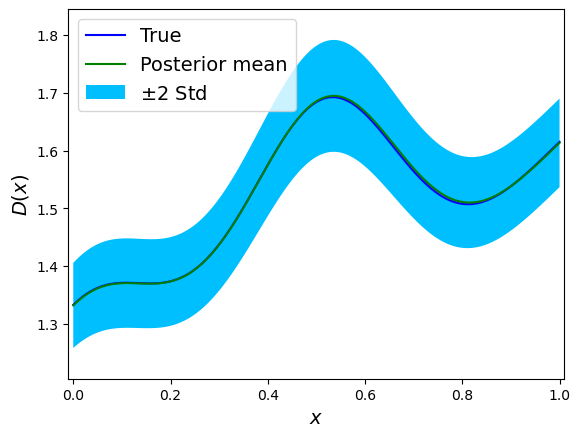

In [36]:
idx_test = 244
N_posterior_sample = 2000
sensor_index = np.arange(1, Nx_dim-1, 20)
D_Bayes_sample, f_Bayes_sample, D_params_Bayes_sample, f_params_Bayes_sample = PI_INN_Bayesian_Sampling(u_test[idx_test:idx_test+1, sensor_index], N_posterior_sample, sensor_index)
D_true = D_test[idx_test]

def visualize_posterior(D_true, D_Bayes_sample):
    Mean_D_Bayes_sample = D_Bayes_sample.mean(0).cpu().detach().numpy()
    Std_D_Bayes_sample = torch.std(D_Bayes_sample, dim=0, unbiased=True).cpu().detach().numpy()
    
    plt.style.use('default')
    node = np.linspace(0, 1, Nx_dim)
    D_lb = Mean_D_Bayes_sample - 3 * Std_D_Bayes_sample
    D_ub = Mean_D_Bayes_sample + 3 * Std_D_Bayes_sample
    
    plt.plot(node, D_true.detach().numpy(), label='True', color='blue')
    plt.plot(node, Mean_D_Bayes_sample, label='Posterior mean', color='green')
    plt.xlabel(r'$x$', fontsize=14)
    plt.ylabel(r'$D(x)$', fontsize=14)
    plt.xlim([-0.01, 1.01])
    
    ylim_span = D_ub.max() - D_lb.min()
    ylim_min = D_lb.min() - 0.1 * ylim_span
    ylim_max = D_ub.max() + 0.1 * ylim_span
    plt.ylim([ylim_min, ylim_max])
    plt.fill_between(node, D_lb, D_ub, facecolor='deepskyblue', label=r'$\pm 2$' + ' Std')
    plt.legend(loc='best', fontsize=14)
    
visualize_posterior(D_true, D_Bayes_sample)
"""
It is noteworthy that the posterior p(k|u) may not Gaussian;therefore, the posterior mean may not
serve as the optimal point estimate for k.
"""